<a href="https://colab.research.google.com/github/isuruK2003/SentimentAnalysis/blob/main/sentiment_analysis_with_logistics_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis With Logistics Regression

### 1) Importing Data

In [25]:
# !pip install nltk
# !pip install numpy pandas
# !pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.0.0-cp313-cp313-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.0 MB 1.6 MB/s eta 0:00:05
   --- ------------------------------------ 0.8/8.0 MB 1.3 MB/s eta 0:00:06
   ----- ---------------------------------- 1.0/8.0 MB 1.4 MB/s eta 0:00:06
   ------ --------------------------------- 1.3/8.0 MB 1.4 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/8.0 MB 1.4 MB/s eta 0:00:05
   ---------- ----------------------------- 2.1/8.0 MB 1.5 MB/s eta 0:00:04
   ------------- -------------------------- 2.6/8.0 MB 1.5

In [12]:
from os import getcwd
import nltk
from nltk.corpus import twitter_samples

In [13]:
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)

In [15]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [16]:
# split the data into two pieces, one for training and one for testing (validation set)
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

In [19]:
import numpy as np

In [20]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

### 2) Data Processing

In [21]:
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [22]:
def process_tweet(tweet):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english') # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet) # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet) # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet) # remove hashtags
    tweet = re.sub(r'#', '', tweet) # only removing the hash # sign from the word
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)
    return tweets_clean

In [23]:
def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [24]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

type(freqs) = <class 'dict'>
len(freqs) = 11427
This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


### 3) Sigmoid Function

- The sigmoid function is defined as:

$$ h(z) = \frac{1}{1+\exp^{-z}} \tag{1}$$

- It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability.

In [26]:
import matplotlib.pyplot as plt

In [27]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

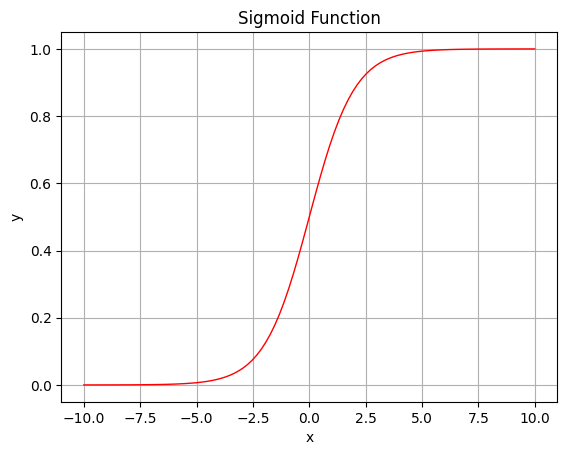

In [28]:
# Generate x values using NumPy
xs = np.linspace(-10, 10, 100)  # 100 evenly spaced points from -50 to 50
ys = sigmoid(xs)

# Plot the data
plt.plot(xs, ys, color="red", linewidth=1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sigmoid Function")
plt.grid()
plt.show()

### 4) Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of training example 'i'.
* $h(z^{(i)})$ is the model's prediction for the training example 'i'.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

* All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label 'y' is also 1, the loss for that training example is 0.
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0.
* However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.

In [29]:
def cost(y, h):
    J = - y * np.log(h) - (1 - y) * np.log(1 - h)
    return np.mean(J)

### 5) Extracting the Features

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet.
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set.

In [30]:
def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    Input:
        tweet: a string containing one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output:
        x: a feature vector of dimension (1,3)
    '''
    word_l = process_tweet(tweet)
    x = np.zeros(3)
    x[0] = 1

    for word in word_l:
        x[1] += freqs[(word, 1.0)] if (word, 1.0) in freqs else 0
        x[2] += freqs[(word, 0.0)] if (word, 0.0) in freqs else 0
    x = x[None, :]

    assert(x.shape == (1, 3))
    return x

In [31]:
X = np.zeros((len(train_x), 3))  # 3 is the number of features from extract_features
for i in range(len(train_x)):
    X[i, :] = extract_features(train_x[i], freqs)

# Training labels corresponding to X
Y = np.array(train_y).reshape(-1, 1)  # Ensure Y is a column vector

### 6) Gradient Descent

#### Update the weights

To update weight vector $\theta$, apply gradient descent to iteratively improve your model's predictions.  
The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x^{(i)}_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.



### Implementing gradient descent function.
* The number of iterations 'num_iters" is the number of times that you'll use the entire training set.
* For each iteration, calculate the cost function using all training examples (there are 'm' training examples), and for all features.
* Instead of updating a single weight $\theta_i$ at a time, we can update all the weights in the column vector:  
$$\mathbf{\theta} = \begin{pmatrix}
\theta_0
\\
\theta_1
\\
\theta_2
\\
\vdots
\\
\theta_n
\end{pmatrix}$$
* $\mathbf{\theta}$ has dimensions (n+1, 1), where 'n' is the number of features, and there is one more element for the bias term $\theta_0$ (note that the corresponding feature value $\mathbf{x_0}$ is 1).
* The 'logits', 'z', are calculated by multiplying the feature matrix 'x' with the weight vector 'theta'.  $z = \mathbf{x}\mathbf{\theta}$
    * $\mathbf{x}$ has dimensions (m, n+1)
    * $\mathbf{\theta}$: has dimensions (n+1, 1)
    * $\mathbf{z}$: has dimensions (m, 1)
* The prediction 'h', is calculated by applying the sigmoid to each element in 'z': $h(z) = sigmoid(z)$, and has dimensions (m,1).
* The cost function $J$ is calculated by taking the dot product of the vectors 'y' and 'log(h)'.  Since both 'y' and 'h' are column vectors (m,1), transpose the vector to the left, so that matrix multiplication of a row vector with column vector performs the dot product.
$$J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$$
* The update of theta is also vectorized.  Because the dimensions of $\mathbf{x}$ are (m, n+1), and both $\mathbf{h}$ and $\mathbf{y}$ are (m, 1), we need to transpose the $\mathbf{x}$ and place it on the left in order to perform matrix multiplication, which then yields the (n+1, 1) answer we need:
$$\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$$

In [33]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: final weight vector
    '''

    m = len(x)
    j_list = []
    for i in range(0, num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)
        J = cost(y, h)
        j_list.append(J)
        grads = np.dot(x.T, (h - y))
        theta = theta - (alpha / m) * grads
        if i % 500 == 0:
            print(f"Epoch {i} : Cost = {J}")

    return j_list, theta

Epoch 0 : Cost = 0.6931471805599454
Epoch 500 : Cost = 0.3850158633066431
Epoch 1000 : Cost = 0.27762430335535454
Epoch 1500 : Cost = 0.22513495105657522
Epoch 2000 : Cost = 0.19437922738837177
Epoch 2500 : Cost = 0.17421555565256575
Epoch 3000 : Cost = 0.15995415840187935
Epoch 3500 : Cost = 0.1493040391065371
Epoch 4000 : Cost = 0.1410207366814509
Epoch 4500 : Cost = 0.13437236864047425
Epoch 5000 : Cost = 0.12890113513003695
Epoch 5500 : Cost = 0.12430624167503027
Epoch 6000 : Cost = 0.12038196343497232
Epoch 6500 : Cost = 0.1169828295479144
Epoch 7000 : Cost = 0.11400304344792093
Epoch 7500 : Cost = 0.11136379243960506
Epoch 8000 : Cost = 0.1090051345498817
Epoch 8500 : Cost = 0.1068806475550266
Epoch 9000 : Cost = 0.10495380261452976
Epoch 9500 : Cost = 0.1031954472669525
The cost after training is 0.10158512.
The resulting vector of weights is [np.float64(3.1e-07), np.float64(0.00127481), np.float64(-0.00110868)]


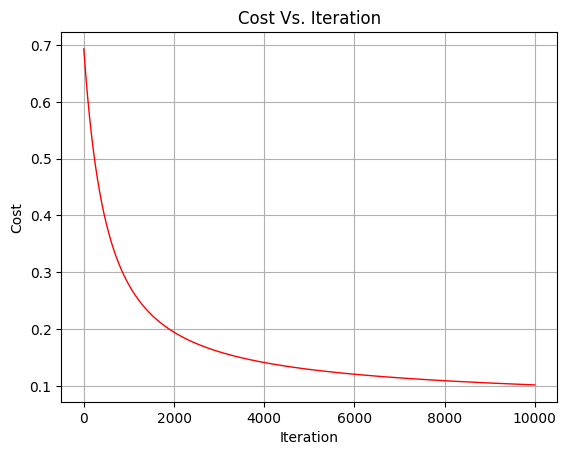

In [34]:
# Gradient descent parameters
iterations = 10_000
learning_rate = 1e-9
initial_theta = np.zeros((3, 1))

# Apply gradient descent
j_list, theta = gradientDescent(X, Y, initial_theta, learning_rate, iterations)

# Output the results
print(f"The cost after training is {j_list[-1]:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

# Plot the cost over iterations
plt.plot(range(iterations), j_list, color="red", linewidth=1)  # Corrected 'width' to 'linewidth'
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Vs. Iteration")
plt.grid()

### 7) Testing

In [35]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input:
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output:
        y_pred: the probability of a tweet being positive or negative
    '''
    x = extract_features(tweet, freqs)
    y_pred = sigmoid(np.dot(x, theta))
    return y_pred

In [36]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    """
    Evaluate the accuracy of a logistic regression model on a test set.

    Args:
        test_x (list): A list of tweets.
        test_y (numpy.ndarray): (m, 1) vector of true labels for the tweets.
        freqs (dict): A dictionary with word-label pair frequencies.
        theta (numpy.ndarray): Weight vector (3, 1) for the model.
        predict_tweet (function): Function to predict the label of a tweet.

    Returns:
        float: The accuracy of the predictions.
    """
    y_hat = [
        1.0 if predict_tweet(tweet, freqs, theta) > 0.5 else 0.0
        for tweet in test_x
    ]

    accuracy = np.mean([y_val == pred for pred, y_val in zip(y_hat, test_y)])
    return accuracy

In [37]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Model Accuracy = {tmp_accuracy * 100:3f} %")

Model Accuracy = 99.450000 %


### 8) Conclusion

Logistic regression based sentiment analysis is the classical approach for sentiment analysis, and from the above experiment results it clear that with propper data preprocessing and training techniques, it is possible to build a solid sentiment classifier, even with the most classical approach.

In [38]:
# Final Classifier

def categorize_tweet(tweet, ambiguity_threshold=0.01):
    """
    Categorize a tweet into Positive, Negative, or Ambiguous based on its sentiment score.

    Args:
        tweet (str): The tweet to categorize.
        freqs (dict): A dictionary with word-label pair frequencies.
        theta (numpy.ndarray): Weight vector for the model.
        predict_tweet (function): Function to predict the label of a tweet.
        ambiguity_threshold (float): Threshold for categorizing a prediction as ambiguous.

    Returns:
        dict: A dictionary with the predicted value and its category.
    """
    # Safely extract the prediction as a scalar
    prediction = float(predict_tweet(tweet, freqs, theta)[0].item())

    if abs(prediction - 0.5) < ambiguity_threshold:
        category = "Ambiguous"
    else:
        category = "Positive" if prediction > 0.5 else "Negative"

    return {"value": prediction, "category": category}


In [39]:
categorize_tweet("i love python")

{'value': 0.5711210945167496, 'category': 'Positive'}